# Plotting the t-SNE
After extracting and embedding features in the previous notebook, this one prepares plots of the dataset according to the embedding.

In [1]:
import pandas
import pathlib
import numpy
from matplotlib import cm, gridspec, pyplot, patches

import bletl

DP_DATA = pathlib.Path("..", "data")
DP_RESULTS = pathlib.Path("..", "results")

## Load the data & embedding

In [2]:
# experimental data
bldata = bletl.parse(DP_DATA / "8X4PF4.csv")
df_samplings = pandas.read_excel(
    DP_DATA / "8X4PF4_eventlog.xlsx",
    index_col=0, sheet_name="samplings"
).set_index("well").sort_index()
df_composition = pandas.read_excel(
    DP_DATA / "8X4PF4_medium_composition.xlsx",
    sheet_name="c_mass_per_µL", index_col=0
)
df_composition /= sum(df_composition.loc["A01"])

# embedding
df_embedding = pandas.read_excel(DP_RESULTS / "8X4PF4_embedding.xlsx", index_col=0)
XY = df_embedding.values
XY = (XY - numpy.min(XY, axis=0)) / numpy.ptp(XY, axis=0)

## Plot time series arranged by t-SNE

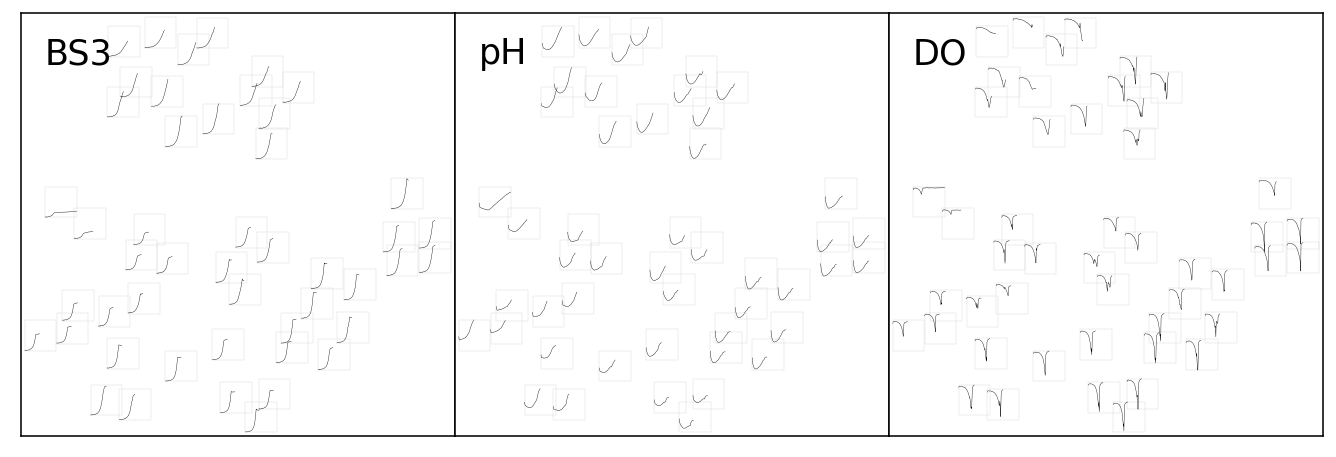

In [3]:
fig, axs = pyplot.subplots(dpi=140, ncols=3, nrows=1, figsize=(12, 4))

for ax, fs in zip(axs.flatten(), bldata):    

    # find maximum values for scaling the small plots
    tmax = 0
    ymin = 1000
    ymax = 0
    for well in df_embedding.index:
        t, y = bldata.get_timeseries(fs, well, last_cycle=df_samplings.loc[well, "cycle"])
        tmax = max(tmax, t.max())
        ymin = min(ymin, y.min())
        ymax = max(ymax, y.max())

    # plot data from each well into a small rectangle, positioned in the t-SNE layout
    for well, (t1, t2) in zip(df_embedding.index, XY):
        t, y = bldata.get_timeseries(fs, well, last_cycle=df_samplings.loc[well, "cycle"])
        w = 0.08

        t = t1 - w/2 + t / tmax * w
        y = t2 - w/2 + (y - ymin) / (ymax - ymin) * w
        ax.plot(t, y, linewidth=0.2, color="black")
        ax.add_patch(
            patches.Rectangle((t1-w/2, t2-w/2), w, w, linewidth=0.2, edgecolor="lightgray", facecolor='none')
        )
    
    ax.text(0.01, 0.99, fs, ha="left", va="top", fontsize=18)
    
for ax in axs.flatten():
    ax.set(
        xticks=[], yticks=[],
        xlim=(-0.05, 1.05),
        ylim=(-0.05, 1.05),
    )
fig.subplots_adjust(hspace=0, wspace=0)
fig.savefig(DP_RESULTS / "fig_tsne_timeseries.pdf", bbox_inches='tight')
fig.savefig(DP_RESULTS / "fig_tsne_timeseries.png", bbox_inches='tight')
pyplot.show()

## Color by medium composition
Some clusters from the t-SNE are explained by certain components in the medium!

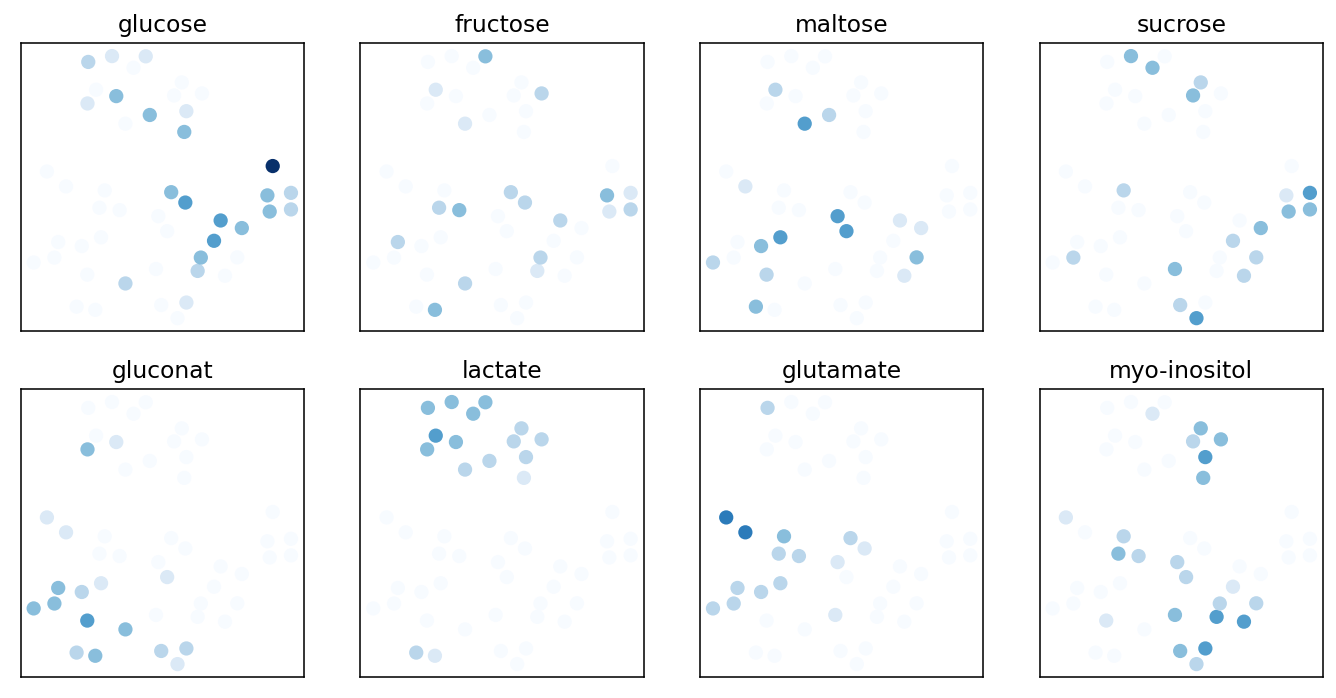

In [4]:
fig, axs = pyplot.subplots(nrows=2, ncols=4, figsize=(12, 6), dpi=140, sharex=True, sharey=True)

for ax, csource in zip(axs.flatten(), df_composition.columns):
    colors = cm.Blues(df_composition[csource])
    ax.scatter(
        XY[:,0], XY[:,1],
        s=40,
        facecolor=colors,
        edgecolor=colors
    )
    ax.set_title(csource)
    ax.set(xticks=[], yticks=[])
    
fig.savefig(DP_RESULTS / "fig_tsne_patterns.pdf", bbox_inches='tight')
fig.savefig(DP_RESULTS / "fig_tsne_patterns.png", bbox_inches='tight')
pyplot.show()

## Show examples of wells with similar time series
Wells that have similar trends in the online signals are co-located in the embedding.

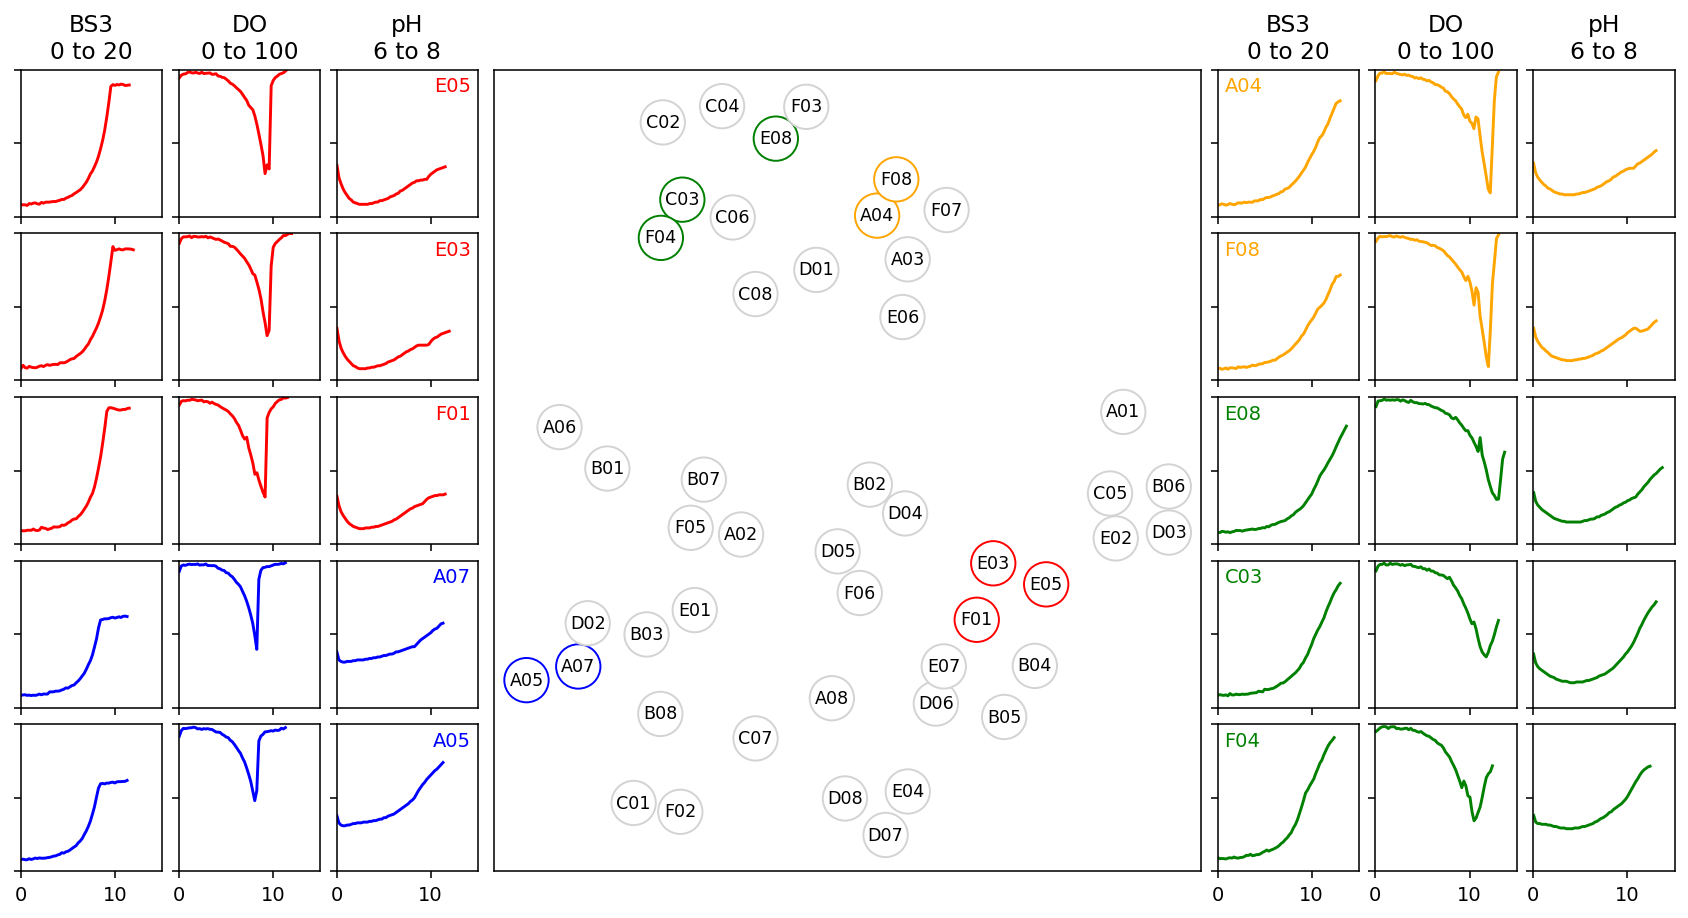

In [5]:
wells_colors = {
    "E05": "red",
    "E03": "red",
    "F01": "red",
    "A07": "blue",
    "A05": "blue",
    "A04": "orange",
    "F08": "orange",
    "E08": "green",
    "C03": "green",
    "F04": "green",
}
assert len(wells_colors) % 2 == 0
R = int(len(wells_colors) / 2)
fig = pyplot.figure(
    dpi=140,
    figsize=(12, 6.5)
)
gs = gridspec.GridSpec(
    ncols=3+1+3, nrows=R,
    figure=fig,
    width_ratios=[1, 1, 1, R, 1, 1, 1]
)
ax = fig.add_subplot(gs[:, 3])
ax.scatter(
    XY[:,0], XY[:,1],
    s=520, marker="o",
    facecolor="white",
    edgecolor=[
        wells_colors.get(well, "lightgray")
        for well in df_embedding.index
    ]
)
for well, (t1, t2) in zip(df_embedding.index, XY):
    ax.annotate(
        well, (t1, t2),
        horizontalalignment="center", verticalalignment="center",
        fontsize=9
    )
# formatting the center plot
ax.set_xticks([])
ax.set_yticks([])

# mini plots
# Acessing the small subplots by (well, fs) keys is a lot easier
# than indexing them from arrays.
axs = {}
for w, well in enumerate(wells_colors.keys()):
    r = int(w % R)
    for f, fs in enumerate(["BS3", "DO", "pH"]):
        c = int(f + (w >= R) * 4)
        axs[(well, fs)] = fig.add_subplot(gs[r, c])
X_LIM = (0, 15)
Y_LIM = {
    "BS3": (0, 20),
    "DO": (0, 100),
    "pH": (6, 8),
}
for w, (well, color) in enumerate(wells_colors.items()):
    r = int(w % R)
    for f, fs in enumerate(["BS3", "DO", "pH"]):
        c = int(f + (w >= R) * 4)
        ax = axs[(well, fs)]
        ymin, ymax = Y_LIM[fs]
        ax.set(
            xlim=X_LIM,
            ylim=(ymin, ymax),
        )
        if r == 0:
            ax.set_title(f"{fs}\n{ymin} to {ymax}")
        if r < R -1:
            ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.plot(
            *bldata.get_timeseries(fs, well, last_cycle=df_samplings.loc[well, "cycle"]),
            color=wells_colors.get(well)
        )
        if c == 2:
            ax.text(
                x=0.95, y=0.85, transform=ax.transAxes, horizontalalignment="right",
                s=well, color=wells_colors.get(well)
            )
        elif c == 4:
            ax.text(
                x=0.05, y=0.85, transform=ax.transAxes, horizontalalignment="left",
                s=well, color=wells_colors.get(well)
            )
fig.tight_layout(pad=0.5)
fig.savefig(DP_RESULTS / "fig_tsne_examples.pdf")
fig.savefig(DP_RESULTS / "fig_tsne_examples.png")
pyplot.show()

In [6]:
%load_ext watermark
%watermark

Last updated: 2021-07-30T21:50:35.633316+02:00

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.25.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 6
Architecture: 64bit

